# Training fixed temperature neural network

The first step before training the neural network is to generate the relevant datasets and load relevant modules.

In [1]:
!python3 ../deep_continuation/dataset.py --size 10000 --seed 1;
!python3 ../deep_continuation/dataset.py --size 100000 --seed 0;

loading existing /home/simon/deep_continuation/deep_continuation/data/unbiased/sigma_10000x1x1_seed1_Nw512_wmax20.npy
loading existing /home/simon/deep_continuation/deep_continuation/data/unbiased/Pi_10000x1x1_seed1_Nwn128_beta30.npy
["/home/simon/deep_continuation/deep_continuation/data/unbiased/Pi_10000x1x1_seed1_Nwn128_beta30.npy", "/home/simon/deep_continuation/deep_continuation/data/unbiased/sigma_10000x1x1_seed1_Nw512_wmax20.npy", "10000x1x1_seed1_beta30_512x128_wmax20"]
loading existing /home/simon/deep_continuation/deep_continuation/data/unbiased/sigma_100000x1x1_seed0_Nw512_wmax20.npy
loading existing /home/simon/deep_continuation/deep_continuation/data/unbiased/Pi_100000x1x1_seed0_Nwn128_beta30.npy
["/home/simon/deep_continuation/deep_continuation/data/unbiased/Pi_100000x1x1_seed0_Nwn128_beta30.npy", "/home/simon/deep_continuation/deep_continuation/data/unbiased/sigma_100000x1x1_seed0_Nw512_wmax20.npy", "100000x1x1_seed0_beta30_512x128_wmax20"]


In [2]:
import os
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
TORCH_MAX = torch.finfo(torch.float64).max

from deep_continuation.dataset import get_file_paths, DATAPATH


## Dataloaders

We shall load the relevant data inside a customized PyTorch `Dataset` subclass contained in a `Dataloader`. This is standard PyTorch practice to automatize the shuffling of the data.

In [3]:
class ContinuationData(torch.utils.data.Dataset):
    def __init__(
        self, noise=0.0, standardize=True, avg=None, std=None,
        # dataset file info
        path=os.path.join(DATAPATH, "unbiased"),
        size=1, seed=0, num_std=1, num_beta=1,
        Nwn=128, beta=30, Nw=512, wmax=20, fixstd=False,
    ):
        _, pi_path, sigma_path, _, _, _ = get_file_paths(
            path, size, seed, num_std, num_beta, Nwn, beta, Nw, wmax, fixstd,
        )
        self.x_data = np.load(pi_path)
        self.y_data = np.load(sigma_path)

        self.noise = noise
        self.standardize = standardize
        if avg and std:
            self.avg = avg
            self.std = std
        else:
            self.avg = self.x_data.mean(axis=-2)
            self.std = self.x_data.std(axis=-2)
        
    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, index):
        x = self.x_data[index]
        x += np.random.normal(0,1, size=x.shape)*self.noise
        if self.standardize:
            x = (x - self.avg)/self.std

        y = self.y_data[index]
        return x, y

print("loading data...")
valid_set = ContinuationData(size=10000, seed=1)
train_set = ContinuationData(size=100000, seed=0)

train_loader = torch.utils.data.DataLoader(
    train_set, 
    batch_size=523, 
    shuffle=True, 
    drop_last=True
)
valid_loader = torch.utils.data.DataLoader(
    valid_set, 
    batch_size=523, 
    shuffle=False, 
    drop_last=True,
)
print(" done")

loading data...
 done


## Define the Model and initialize weights

In [4]:
class MLP(nn.Module):
    def __init__(self, layers=[128, 952, 1343, 1673, 1722, 512]):
        super(MLP, self).__init__()
        self.epoch = 0
        
        self.layers = nn.ModuleList()
        sizeA = layers[0]
        for sizeB in layers[1:]:
            self.layers.append(nn.Linear(sizeA, sizeB))
            self.layers.append(nn.ReLU())
            sizeA = sizeB

        self.layers.append(nn.Linear(sizeA, layers[-1]))
        self.layers.append(nn.Softmax(dim=-1))
        
    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer(out)
        return out


def initialize_weights(module, gain=1):
    if type(module) == nn.Linear:
        torch.nn.init.xavier_uniform_(module.weight, gain=gain)
        torch.nn.init.zeros_(module.bias)

model = MLP().to(device)
model.apply(initialize_weights)

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=128, out_features=952, bias=True)
    (1): ReLU()
    (2): Linear(in_features=952, out_features=1343, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1343, out_features=1673, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1673, out_features=1722, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1722, out_features=512, bias=True)
    (9): ReLU()
    (10): Linear(in_features=512, out_features=512, bias=True)
    (11): Softmax(dim=-1)
  )
)

## Define the loss function, optimizer, and learning rate scheduler

In [5]:
loss_function = nn.L1Loss()  
mse_function = nn.MSELoss()

lr = 8e-5
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    factor=0.216, 
    patience=5,
    verbose=True,
    min_lr=1e-10
)

## Training and validation loop
Use a learning rate warmup, early stopping and plot a spectrum each epoch 

 epoch 1
   train loss: 0.001287472, mse: 0.000010027
   valid loss: 0.000948378, mse:0.000007308
 epoch 2
   train loss: 0.000883178, mse: 0.000008092
   valid loss: 0.000834451, mse:0.000006696
 epoch 3
   train loss: 0.000810155, mse: 0.000007693
   valid loss: 0.000780764, mse:0.000006439
 epoch 4
   train loss: 0.000771467, mse: 0.000007446
   valid loss: 0.000753875, mse:0.000006264
 epoch 5
   train loss: 0.000749014, mse: 0.000007298
   valid loss: 0.000741991, mse:0.000006160
 epoch 6
   train loss: 0.000733946, mse: 0.000007202
   valid loss: 0.000721594, mse:0.000006072
 epoch 7
   train loss: 0.000717387, mse: 0.000007108
   valid loss: 0.000710473, mse:0.000005972
 epoch 8
   train loss: 0.000706256, mse: 0.000007027
   valid loss: 0.000701996, mse:0.000005938
 epoch 9
   train loss: 0.000696319, mse: 0.000006961
   valid loss: 0.000690948, mse:0.000005855
 epoch 10
   train loss: 0.000687375, mse: 0.000006901
   valid loss: 0.000678276, mse:0.000005801


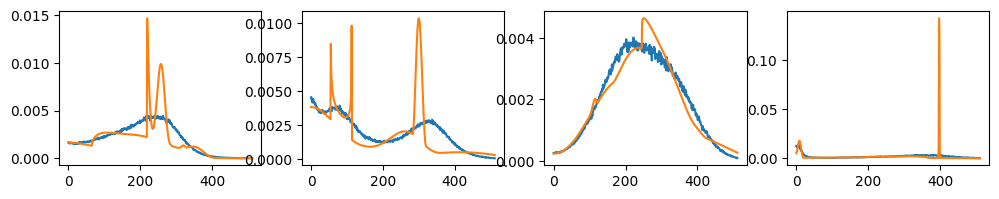

 epoch 11
   train loss: 0.000683497, mse: 0.000006867
   valid loss: 0.000675523, mse:0.000005776
 epoch 12
   train loss: 0.000673460, mse: 0.000006807
   valid loss: 0.000670329, mse:0.000005722
 epoch 13
   train loss: 0.000669720, mse: 0.000006775
   valid loss: 0.000662255, mse:0.000005690
 epoch 14
   train loss: 0.000663685, mse: 0.000006736
   valid loss: 0.000660414, mse:0.000005661
 epoch 15
   train loss: 0.000660142, mse: 0.000006708
   valid loss: 0.000658561, mse:0.000005663
 epoch 16
   train loss: 0.000655355, mse: 0.000006671
   valid loss: 0.000654351, mse:0.000005608
 epoch 17
   train loss: 0.000654428, mse: 0.000006658
   valid loss: 0.000647837, mse:0.000005580
 epoch 18
   train loss: 0.000650085, mse: 0.000006631
   valid loss: 0.000673210, mse:0.000005725
 epoch 19
   train loss: 0.000647262, mse: 0.000006603
   valid loss: 0.000654312, mse:0.000005563
 epoch 20
   train loss: 0.000643874, mse: 0.000006578
   valid loss: 0.000651411, mse:0.000005549


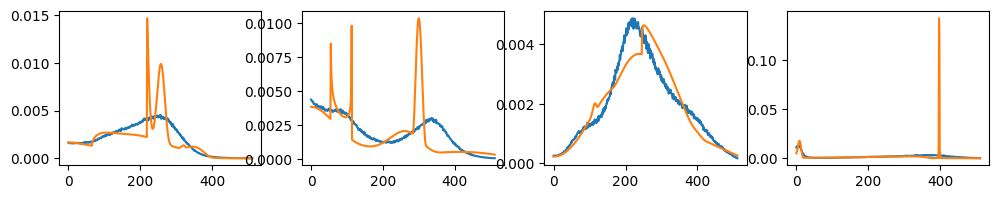

 epoch 21
   train loss: 0.000645317, mse: 0.000006575
   valid loss: 0.000642686, mse:0.000005500
 epoch 22
   train loss: 0.000637579, mse: 0.000006535
   valid loss: 0.000641423, mse:0.000005510
 epoch 23
   train loss: 0.000636801, mse: 0.000006518
   valid loss: 0.000634937, mse:0.000005450
 epoch 24
   train loss: 0.000635264, mse: 0.000006501
   valid loss: 0.000633871, mse:0.000005453
 epoch 25
   train loss: 0.000631586, mse: 0.000006484
   valid loss: 0.000643042, mse:0.000005485
 epoch 26
   train loss: 0.000629548, mse: 0.000006463
   valid loss: 0.000660751, mse:0.000005564
 epoch 27
   train loss: 0.000628039, mse: 0.000006450
   valid loss: 0.000629589, mse:0.000005421
 epoch 28
   train loss: 0.000627555, mse: 0.000006440
   valid loss: 0.000624338, mse:0.000005433
 epoch 29
   train loss: 0.000626942, mse: 0.000006426
   valid loss: 0.000627931, mse:0.000005387
 epoch 30
   train loss: 0.000622262, mse: 0.000006398
   valid loss: 0.000628370, mse:0.000005375


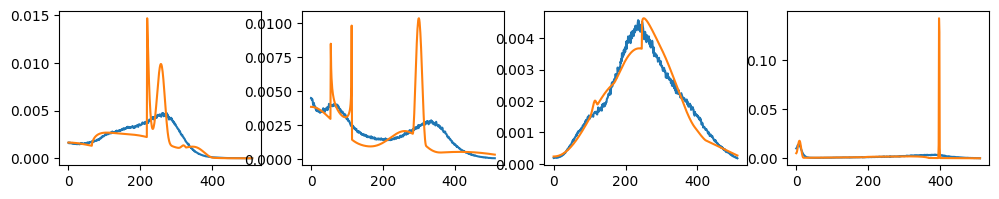

 epoch 31
   train loss: 0.000619682, mse: 0.000006388
   valid loss: 0.000617266, mse:0.000005357
 epoch 32
   train loss: 0.000618071, mse: 0.000006368
   valid loss: 0.000616725, mse:0.000005307
 epoch 33
   train loss: 0.000617973, mse: 0.000006360
   valid loss: 0.000618211, mse:0.000005335
 epoch 34
   train loss: 0.000613601, mse: 0.000006336
   valid loss: 0.000614674, mse:0.000005301
 epoch 35
   train loss: 0.000614410, mse: 0.000006314
   valid loss: 0.000627636, mse:0.000005385
 epoch 36
   train loss: 0.000612274, mse: 0.000006309
   valid loss: 0.000631453, mse:0.000005441
 epoch 37
   train loss: 0.000612211, mse: 0.000006309
   valid loss: 0.000608193, mse:0.000005284
 epoch 38
   train loss: 0.000609944, mse: 0.000006297
   valid loss: 0.000610509, mse:0.000005280
 epoch 39
   train loss: 0.000609513, mse: 0.000006287
   valid loss: 0.000611885, mse:0.000005260
 epoch 40
   train loss: 0.000607356, mse: 0.000006276
   valid loss: 0.000615804, mse:0.000005253


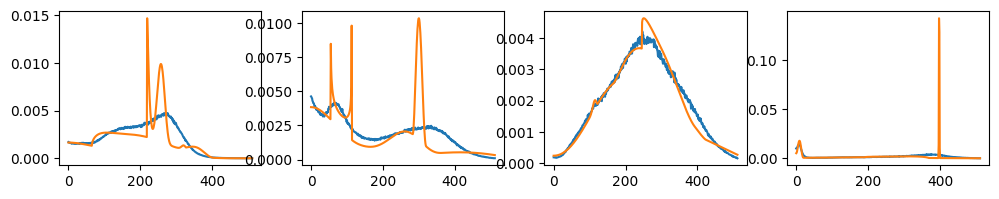

 epoch 41
   train loss: 0.000606016, mse: 0.000006259
   valid loss: 0.000609617, mse:0.000005283
 epoch 42
   train loss: 0.000603317, mse: 0.000006236
   valid loss: 0.000628387, mse:0.000005362
 epoch 43
   train loss: 0.000604211, mse: 0.000006241
   valid loss: 0.000612866, mse:0.000005328
 epoch 44
   train loss: 0.000603140, mse: 0.000006233
   valid loss: 0.000603415, mse:0.000005222
 epoch 45
   train loss: 0.000602751, mse: 0.000006225
   valid loss: 0.000602920, mse:0.000005225
 epoch 46
   train loss: 0.000598956, mse: 0.000006200
   valid loss: 0.000627395, mse:0.000005338
 epoch 47
   train loss: 0.000599294, mse: 0.000006200
   valid loss: 0.000600516, mse:0.000005191
 epoch 48
   train loss: 0.000598861, mse: 0.000006190
   valid loss: 0.000608368, mse:0.000005199
 epoch 49
   train loss: 0.000598803, mse: 0.000006188
   valid loss: 0.000616189, mse:0.000005231
 epoch 50
   train loss: 0.000597065, mse: 0.000006173
   valid loss: 0.000609260, mse:0.000005192


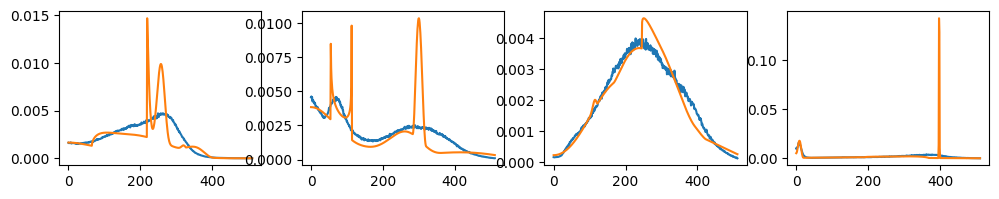

 epoch 51
   train loss: 0.000597156, mse: 0.000006165
   valid loss: 0.000639525, mse:0.000005368
 epoch 52
   train loss: 0.000595930, mse: 0.000006156
   valid loss: 0.000602495, mse:0.000005202
 epoch 53
   train loss: 0.000592993, mse: 0.000006131
   valid loss: 0.000601534, mse:0.000005213
 epoch 54
   train loss: 0.000592924, mse: 0.000006126
   valid loss: 0.000596847, mse:0.000005162
 epoch 55
   train loss: 0.000591178, mse: 0.000006114
   valid loss: 0.000602597, mse:0.000005195
 epoch 56
   train loss: 0.000591838, mse: 0.000006116
   valid loss: 0.000609994, mse:0.000005252
 epoch 57
   train loss: 0.000592208, mse: 0.000006113
   valid loss: 0.000614443, mse:0.000005327
 epoch 58
   train loss: 0.000589895, mse: 0.000006092
   valid loss: 0.000601715, mse:0.000005142
 epoch 59
   train loss: 0.000589383, mse: 0.000006095
   valid loss: 0.000592785, mse:0.000005109
 epoch 60
   train loss: 0.000588445, mse: 0.000006081
   valid loss: 0.000597238, mse:0.000005173


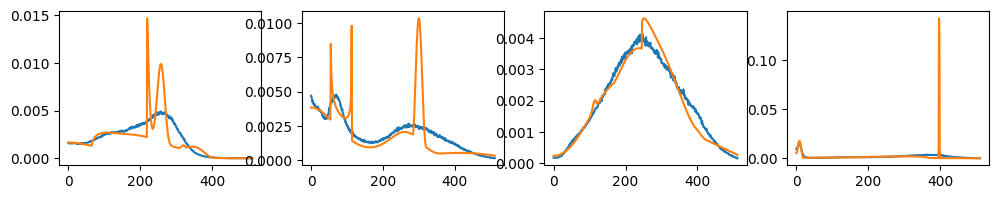

 epoch 61
   train loss: 0.000587402, mse: 0.000006078
   valid loss: 0.000593891, mse:0.000005112
 epoch 62
   train loss: 0.000590632, mse: 0.000006081
   valid loss: 0.000597233, mse:0.000005112
 epoch 63
   train loss: 0.000585313, mse: 0.000006050
   valid loss: 0.000593356, mse:0.000005119
 epoch 64
   train loss: 0.000584113, mse: 0.000006043
   valid loss: 0.000619048, mse:0.000005224
 epoch 65
   train loss: 0.000587468, mse: 0.000006062
   valid loss: 0.000594187, mse:0.000005120
 epoch 66
   train loss: 0.000585242, mse: 0.000006045
   valid loss: 0.000600379, mse:0.000005137
 epoch 67
   train loss: 0.000584196, mse: 0.000006035
   valid loss: 0.000604024, mse:0.000005154
 epoch 68
   train loss: 0.000583595, mse: 0.000006026
   valid loss: 0.000595131, mse:0.000005120
 epoch 69
   train loss: 0.000581392, mse: 0.000006009
   valid loss: 0.000595011, mse:0.000005158
 epoch 70
   train loss: 0.000581264, mse: 0.000006007
   valid loss: 0.000588541, mse:0.000005081


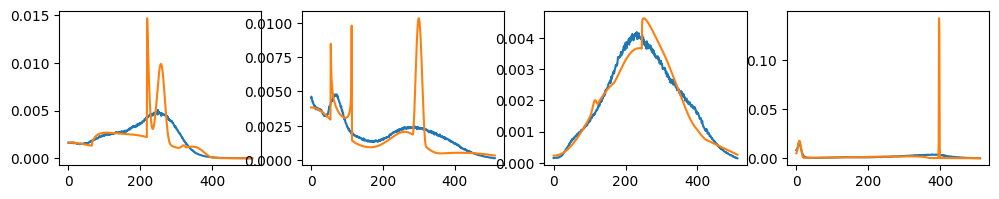

 epoch 71
   train loss: 0.000581706, mse: 0.000006004
   valid loss: 0.000612407, mse:0.000005142
 epoch 72
   train loss: 0.000582446, mse: 0.000005917
   valid loss: 0.000598600, mse:0.000005124
 epoch 73
   train loss: 0.000578410, mse: 0.000005978
   valid loss: 0.000595166, mse:0.000005094
 epoch 74
   train loss: 0.000580477, mse: 0.000005969
   valid loss: 0.000591278, mse:0.000005097
 epoch 75
   train loss: 0.000578226, mse: 0.000005965
   valid loss: 0.000593175, mse:0.000005138
 epoch 76
   train loss: 0.000580692, mse: 0.000005972
   valid loss: 0.000589769, mse:0.000005065
 epoch 77
   train loss: 0.000577348, mse: 0.000005956
   valid loss: 0.000588563, mse:0.000005085
 epoch 78
   train loss: 0.000578763, mse: 0.000005951
   valid loss: 0.000594607, mse:0.000005075
 epoch 79
   train loss: 0.000577841, mse: 0.000005948
   valid loss: 0.000594717, mse:0.000005136
 epoch 80
   train loss: 0.000576632, mse: 0.000005947
   valid loss: 0.000593342, mse:0.000005083


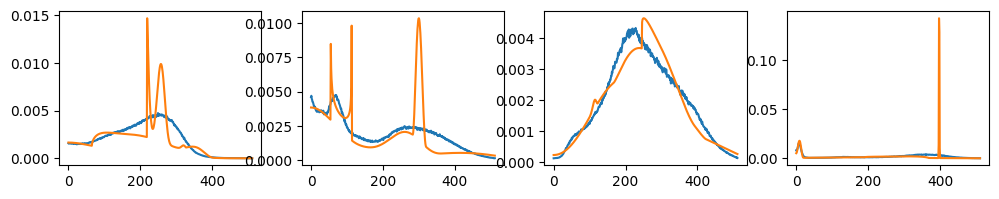

 epoch 81
   train loss: 0.000575372, mse: 0.000005926
   valid loss: 0.000594523, mse:0.000005150
 epoch 82
   train loss: 0.000576676, mse: 0.000005929
   valid loss: 0.000590907, mse:0.000005108
 epoch 83
   train loss: 0.000575195, mse: 0.000005928
   valid loss: 0.000588062, mse:0.000005121
 epoch 84
   train loss: 0.000575083, mse: 0.000005913
   valid loss: 0.000587186, mse:0.000005072
 epoch 85
   train loss: 0.000570825, mse: 0.000005900
   valid loss: 0.000589011, mse:0.000005019
 epoch 86
   train loss: 0.000575717, mse: 0.000005907
   valid loss: 0.000590947, mse:0.000005043
 epoch 87
   train loss: 0.000574053, mse: 0.000005909
   valid loss: 0.000581644, mse:0.000005052
 epoch 88
   train loss: 0.000570276, mse: 0.000005876
   valid loss: 0.000594214, mse:0.000005201
 epoch 89
   train loss: 0.000574463, mse: 0.000005892
   valid loss: 0.000592474, mse:0.000005012
 epoch 90
   train loss: 0.000572330, mse: 0.000005886
   valid loss: 0.000587451, mse:0.000005068


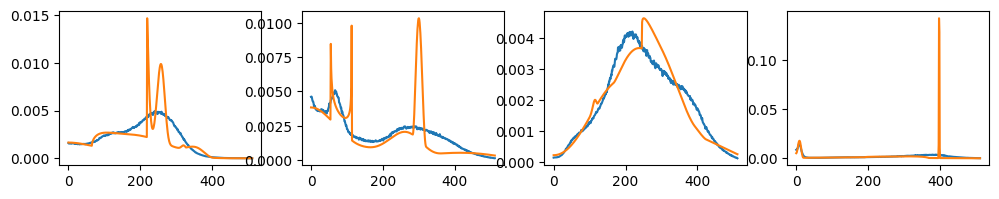

 epoch 91
   train loss: 0.000571110, mse: 0.000005877
   valid loss: 0.000616638, mse:0.000005264
 epoch 92
   train loss: 0.000573415, mse: 0.000005888
   valid loss: 0.000594857, mse:0.000005169
 epoch 93
   train loss: 0.000568518, mse: 0.000005855
   valid loss: 0.000600067, mse:0.000005069
 epoch 94
   train loss: 0.000569307, mse: 0.000005866
   valid loss: 0.000604870, mse:0.000005050
 epoch 95
   train loss: 0.000569892, mse: 0.000005862
   valid loss: 0.000602357, mse:0.000005147
 epoch 96
   train loss: 0.000568789, mse: 0.000005854
   valid loss: 0.000592789, mse:0.000005068
 epoch 97
   train loss: 0.000567985, mse: 0.000005847
   valid loss: 0.000595701, mse:0.000005157
 epoch 98
   train loss: 0.000569484, mse: 0.000005852
   valid loss: 0.000587610, mse:0.000005034
 epoch 99
   train loss: 0.000565894, mse: 0.000005828
   valid loss: 0.000598518, mse:0.000005186
 epoch 100
   train loss: 0.000565095, mse: 0.000005826
   valid loss: 0.000587091, mse:0.000005019


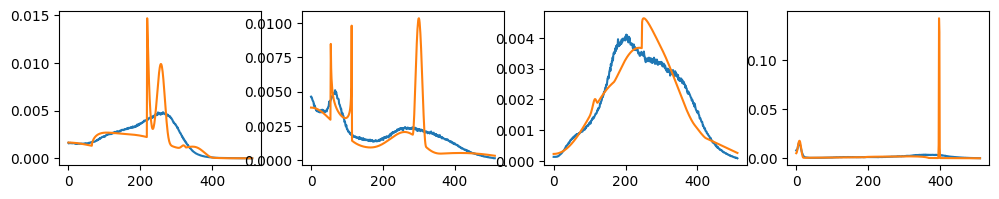

 epoch 101
   train loss: 0.000567733, mse: 0.000005835
   valid loss: 0.000592751, mse:0.000005080
 epoch 102
   train loss: 0.000565343, mse: 0.000005831
   valid loss: 0.000582856, mse:0.000005009
 epoch 103
   train loss: 0.000565417, mse: 0.000005810
   valid loss: 0.000582118, mse:0.000004992
 epoch 104
   train loss: 0.000566941, mse: 0.000005820
   valid loss: 0.000587051, mse:0.000005031
 epoch 105
   train loss: 0.000565672, mse: 0.000005818
   valid loss: 0.000580963, mse:0.000005025
 epoch 106
   train loss: 0.000562779, mse: 0.000005796
   valid loss: 0.000598871, mse:0.000005138
 epoch 107
   train loss: 0.000566830, mse: 0.000005816
   valid loss: 0.000593383, mse:0.000005117
 epoch 108
   train loss: 0.000561811, mse: 0.000005786
   valid loss: 0.000583705, mse:0.000005033
 epoch 109
   train loss: 0.000562383, mse: 0.000005799
   valid loss: 0.000581769, mse:0.000004985
 epoch 110
   train loss: 0.000561107, mse: 0.000005769
   valid loss: 0.000582953, mse:0.000005022


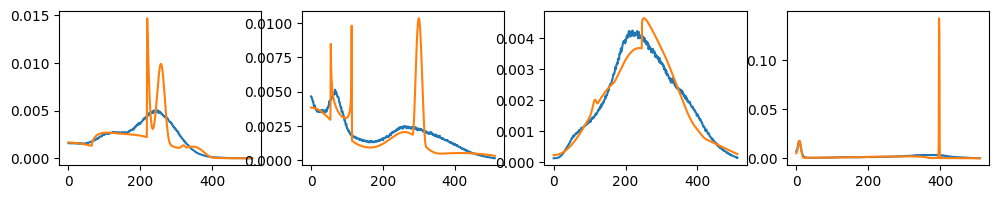

 epoch 111
   train loss: 0.000565289, mse: 0.000005796
   valid loss: 0.000578310, mse:0.000004968
 epoch 112
   train loss: 0.000563030, mse: 0.000005785
   valid loss: 0.000578181, mse:0.000005009
 epoch 113
   train loss: 0.000560384, mse: 0.000005762
   valid loss: 0.000589337, mse:0.000005085
 epoch 114
   train loss: 0.000561022, mse: 0.000005765
   valid loss: 0.000584202, mse:0.000005025
 epoch 115
   train loss: 0.000559122, mse: 0.000005753
   valid loss: 0.000593465, mse:0.000005153
 epoch 116
   train loss: 0.000561646, mse: 0.000005760
   valid loss: 0.000597522, mse:0.000005066
 epoch 117
   train loss: 0.000560831, mse: 0.000005751
   valid loss: 0.000589017, mse:0.000004988
 epoch 118
   train loss: 0.000558033, mse: 0.000005734
   valid loss: 0.000600361, mse:0.000005078
 epoch 119
   train loss: 0.000562135, mse: 0.000005762
   valid loss: 0.000578380, mse:0.000004947
 epoch 120
   train loss: 0.000559704, mse: 0.000005748
   valid loss: 0.000580090, mse:0.000004995


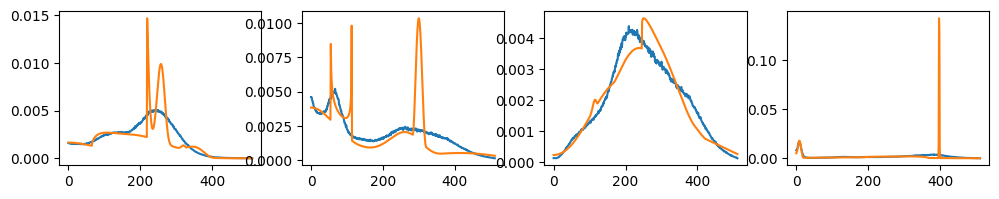

 epoch 121
   train loss: 0.000558387, mse: 0.000005726
   valid loss: 0.000583943, mse:0.000005099
 epoch 122
   train loss: 0.000560193, mse: 0.000005738
   valid loss: 0.000589379, mse:0.000005074
 epoch 123
   train loss: 0.000558426, mse: 0.000005729
   valid loss: 0.000584877, mse:0.000005074
 epoch 124
   train loss: 0.000558401, mse: 0.000005723
   valid loss: 0.000583930, mse:0.000005062
Epoch 00124: reducing learning rate of group 0 to 1.7280e-05.
 epoch 125
   train loss: 0.000538837, mse: 0.000005622
   valid loss: 0.000572358, mse:0.000004965
 epoch 126
   train loss: 0.000536573, mse: 0.000005602
   valid loss: 0.000577501, mse:0.000004975
 epoch 127
   train loss: 0.000536313, mse: 0.000005606
   valid loss: 0.000573591, mse:0.000004949
 epoch 128
   train loss: 0.000535368, mse: 0.000005601
   valid loss: 0.000572803, mse:0.000004946
 epoch 129
   train loss: 0.000535691, mse: 0.000005595
   valid loss: 0.000575906, mse:0.000004991
 epoch 130
   train loss: 0.000535225,

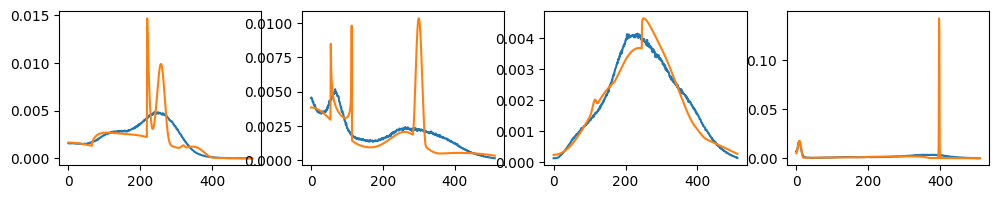

 epoch 131
   train loss: 0.000534353, mse: 0.000005590
   valid loss: 0.000574334, mse:0.000004997
 epoch 132
   train loss: 0.000534592, mse: 0.000005587
   valid loss: 0.000572479, mse:0.000004904
 epoch 133
   train loss: 0.000534231, mse: 0.000005581
   valid loss: 0.000573311, mse:0.000004969
 epoch 134
   train loss: 0.000533795, mse: 0.000005579
   valid loss: 0.000576402, mse:0.000005004
 epoch 135
   train loss: 0.000534372, mse: 0.000005573
   valid loss: 0.000574176, mse:0.000004960
 epoch 136
   train loss: 0.000534068, mse: 0.000005580
   valid loss: 0.000571514, mse:0.000004961
 epoch 137
   train loss: 0.000533518, mse: 0.000005580
   valid loss: 0.000579532, mse:0.000004955
 epoch 138
   train loss: 0.000534444, mse: 0.000005571
   valid loss: 0.000571987, mse:0.000004949
 epoch 139
   train loss: 0.000532782, mse: 0.000005568
   valid loss: 0.000571262, mse:0.000004951
 epoch 140
   train loss: 0.000532405, mse: 0.000005568
   valid loss: 0.000574127, mse:0.000004971


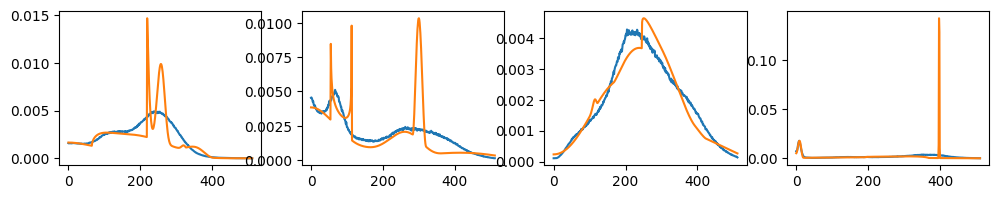

 epoch 141
   train loss: 0.000532550, mse: 0.000005566
   valid loss: 0.000575100, mse:0.000004992
 epoch 142
   train loss: 0.000532211, mse: 0.000005557
   valid loss: 0.000572313, mse:0.000004952
 epoch 143
   train loss: 0.000532892, mse: 0.000005562
   valid loss: 0.000570044, mse:0.000004936
 epoch 144
   train loss: 0.000531905, mse: 0.000005554
   valid loss: 0.000570730, mse:0.000004952
 epoch 145
   train loss: 0.000531639, mse: 0.000005557
   valid loss: 0.000569158, mse:0.000004909
 epoch 146
   train loss: 0.000531986, mse: 0.000005559
   valid loss: 0.000570492, mse:0.000004972
 epoch 147
   train loss: 0.000530310, mse: 0.000005548
   valid loss: 0.000573120, mse:0.000004943
 epoch 148
   train loss: 0.000530648, mse: 0.000005547
   valid loss: 0.000571723, mse:0.000004957
 epoch 149
   train loss: 0.000530122, mse: 0.000005544
   valid loss: 0.000577356, mse:0.000004983
 epoch 150
   train loss: 0.000530419, mse: 0.000005551
   valid loss: 0.000571843, mse:0.000004943


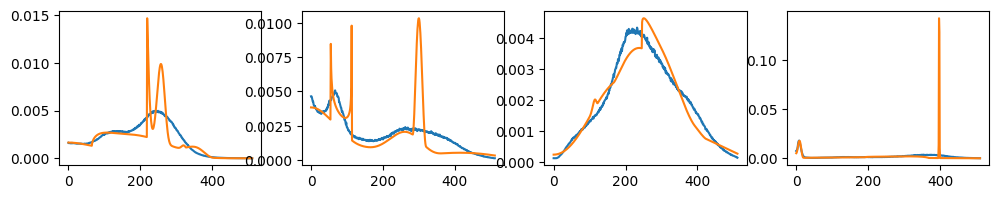

 epoch 151
   train loss: 0.000529826, mse: 0.000005540
   valid loss: 0.000576300, mse:0.000005006
 epoch 152
   train loss: 0.000530105, mse: 0.000005542
   valid loss: 0.000572196, mse:0.000004946
 epoch 153
   train loss: 0.000531073, mse: 0.000005543
   valid loss: 0.000568341, mse:0.000004928
 epoch 154
   train loss: 0.000530361, mse: 0.000005532
   valid loss: 0.000568720, mse:0.000004921
 epoch 155
   train loss: 0.000529409, mse: 0.000005538
   valid loss: 0.000566919, mse:0.000004907
 epoch 156
   train loss: 0.000528996, mse: 0.000005531
   valid loss: 0.000572861, mse:0.000004968
 epoch 157
   train loss: 0.000529596, mse: 0.000005531
   valid loss: 0.000570924, mse:0.000004969
 epoch 158
   train loss: 0.000530549, mse: 0.000005538
   valid loss: 0.000572202, mse:0.000004928
 epoch 159
   train loss: 0.000528607, mse: 0.000005530
   valid loss: 0.000567661, mse:0.000004914
 epoch 160
   train loss: 0.000529392, mse: 0.000005524
   valid loss: 0.000575741, mse:0.000004990


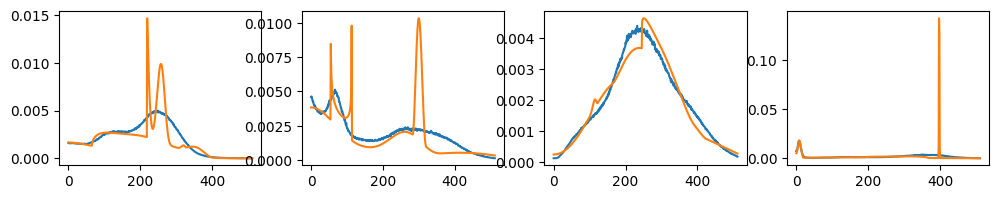

 epoch 161
   train loss: 0.000529068, mse: 0.000005526
   valid loss: 0.000569114, mse:0.000004951
 epoch 162
   train loss: 0.000528920, mse: 0.000005524
   valid loss: 0.000569221, mse:0.000004929
 epoch 163
   train loss: 0.000527477, mse: 0.000005516
   valid loss: 0.000566642, mse:0.000004923
 epoch 164
   train loss: 0.000527209, mse: 0.000005502
   valid loss: 0.000574304, mse:0.000004936
 epoch 165
   train loss: 0.000527343, mse: 0.000005511
   valid loss: 0.000567485, mse:0.000004927
 epoch 166
   train loss: 0.000527694, mse: 0.000005519
   valid loss: 0.000570364, mse:0.000004952
 epoch 167
   train loss: 0.000526658, mse: 0.000005511
   valid loss: 0.000566758, mse:0.000004931
 epoch 168
   train loss: 0.000527733, mse: 0.000005511
   valid loss: 0.000569846, mse:0.000004964
 epoch 169
   train loss: 0.000527691, mse: 0.000005511
   valid loss: 0.000570456, mse:0.000004942
 epoch 170
   train loss: 0.000527888, mse: 0.000005511
   valid loss: 0.000565139, mse:0.000004932


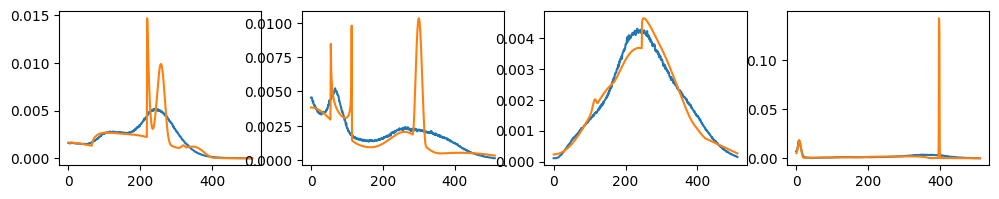

 epoch 171
   train loss: 0.000527645, mse: 0.000005516
   valid loss: 0.000567263, mse:0.000004950
 epoch 172
   train loss: 0.000527318, mse: 0.000005499
   valid loss: 0.000573054, mse:0.000004951
 epoch 173
   train loss: 0.000525642, mse: 0.000005498
   valid loss: 0.000565776, mse:0.000004924
 epoch 174
   train loss: 0.000527085, mse: 0.000005508
   valid loss: 0.000565131, mse:0.000004923
 epoch 175
   train loss: 0.000527193, mse: 0.000005499
   valid loss: 0.000567469, mse:0.000004925
 epoch 176
   train loss: 0.000526936, mse: 0.000005500
   valid loss: 0.000570111, mse:0.000004921
 epoch 177
   train loss: 0.000525827, mse: 0.000005500
   valid loss: 0.000567461, mse:0.000004901
 epoch 178
   train loss: 0.000527926, mse: 0.000005505
   valid loss: 0.000566147, mse:0.000004903
 epoch 179
   train loss: 0.000525451, mse: 0.000005499
   valid loss: 0.000566250, mse:0.000004893
 epoch 180
   train loss: 0.000526017, mse: 0.000005496
   valid loss: 0.000569127, mse:0.000004944


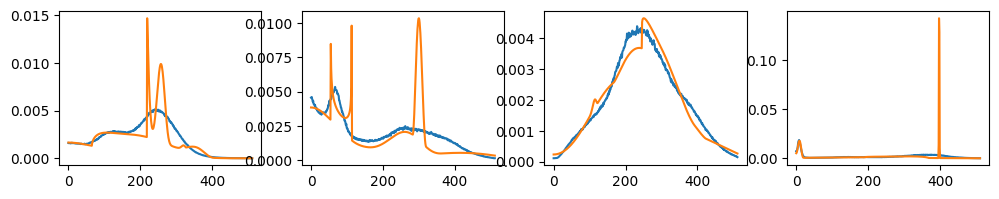

 epoch 181
   train loss: 0.000524998, mse: 0.000005492
   valid loss: 0.000569240, mse:0.000004908
 epoch 182
   train loss: 0.000526403, mse: 0.000005490
   valid loss: 0.000566497, mse:0.000004926
 epoch 183
   train loss: 0.000525434, mse: 0.000005489
   valid loss: 0.000567087, mse:0.000004891
 epoch 184
   train loss: 0.000524805, mse: 0.000005474
   valid loss: 0.000568727, mse:0.000004984
 epoch 185
   train loss: 0.000524029, mse: 0.000005481
   valid loss: 0.000572117, mse:0.000004894
 epoch 186
   train loss: 0.000524308, mse: 0.000005478
   valid loss: 0.000571761, mse:0.000004910
 epoch 187
   train loss: 0.000524952, mse: 0.000005477
   valid loss: 0.000569573, mse:0.000004905
 epoch 188
   train loss: 0.000523995, mse: 0.000005477
   valid loss: 0.000572910, mse:0.000004903
 epoch 189
   train loss: 0.000523643, mse: 0.000005474
   valid loss: 0.000563762, mse:0.000004880
 epoch 190
   train loss: 0.000524799, mse: 0.000005475
   valid loss: 0.000568109, mse:0.000004939


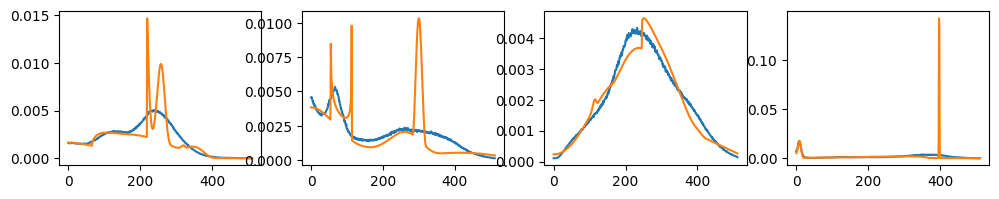

 epoch 191
   train loss: 0.000523517, mse: 0.000005478
   valid loss: 0.000567884, mse:0.000004896
 epoch 192
   train loss: 0.000524572, mse: 0.000005474
   valid loss: 0.000573679, mse:0.000004926
 epoch 193
   train loss: 0.000523756, mse: 0.000005472
   valid loss: 0.000571507, mse:0.000004910
 epoch 194
   train loss: 0.000524095, mse: 0.000005466
   valid loss: 0.000572429, mse:0.000004958
 epoch 195
   train loss: 0.000524259, mse: 0.000005477
   valid loss: 0.000568801, mse:0.000004926
 epoch 196
   train loss: 0.000523665, mse: 0.000005463
   valid loss: 0.000565576, mse:0.000004863
 epoch 197
   train loss: 0.000524341, mse: 0.000005474
   valid loss: 0.000569708, mse:0.000004975
Epoch 00197: reducing learning rate of group 0 to 3.7325e-06.
 epoch 198
   train loss: 0.000518203, mse: 0.000005441
   valid loss: 0.000565569, mse:0.000004912
 epoch 199
   train loss: 0.000517681, mse: 0.000005443
   valid loss: 0.000565856, mse:0.000004914
 epoch 200
   train loss: 0.000517502,

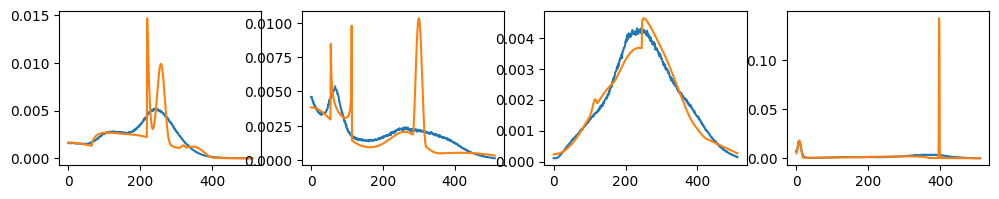

In [6]:
n_epochs = 200
early_stop_count = 40
best_valid_loss = TORCH_MAX
for epoch in range(1, n_epochs+1):
    print(f' epoch {epoch}')
    avg_train_loss = 0
    avg_train_mse = 0

    model.train()
    for batch_number, (inputs, targets) in enumerate(train_loader):
        
        # learning rate warmup
        if epoch == 1: 
            tmp_lr = (batch_number+1)*lr/len(train_loader)
            for g in optimizer.param_groups:
                g['lr'] = tmp_lr

        inputs = inputs.to(device).float()
        targets = targets.to(device).float()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()

        mse = mse_function(outputs, targets)
        avg_train_mse += mse.item()
        avg_train_loss += loss.item()
    
    avg_train_loss = avg_train_loss/len(train_loader)
    avg_train_mse = avg_train_mse/len(train_loader)
    print(f'   train loss: {avg_train_loss:.9f}, mse: {avg_train_mse:.9f}')

    model.eval()
    avg_valid_loss = 0
    avg_valid_mse = 0
    for batch_number, (inputs, targets) in enumerate(valid_loader):
        inputs = inputs.to(device).float()
        targets = targets.to(device).float()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)

        mse = mse_function(outputs, targets)
        avg_valid_loss += loss.item()
        avg_valid_mse += mse.item()

    avg_valid_loss = avg_valid_loss/len(valid_loader)
    avg_valid_mse = avg_valid_mse/len(valid_loader)
    print(f'   valid loss: {avg_valid_loss:.9f}, mse:{avg_valid_mse:.9f}')
    
    # plot a few validation spectra
    if epoch%10==0:
        offset = 10
        n_plots = 4
        _, ax = plt.subplots(1,n_plots, figsize=(12,2))
        for i in range(n_plots):
            ax[i].plot(outputs[i+offset].detach().cpu().numpy())
            ax[i].plot(targets[i+offset].detach().cpu().numpy())
        plt.pause(0.001)
    
    # early stop
    scheduler.step(avg_train_loss)
    early_stop_count -= 1
    if avg_valid_loss < best_valid_loss:
        early_stop_count = 40
        best_valid_loss = avg_valid_loss
        best_epoch = epoch
        best_model = deepcopy(model)
        
    if early_stop_count == 0:
        print('early stopping limit reached!!')
        print(f'best epoch was {best_epoch}')
        break

## Saving the best model

In [7]:
torch.save(best_model.state_dict(), "best_model.pt")

## Loading the model

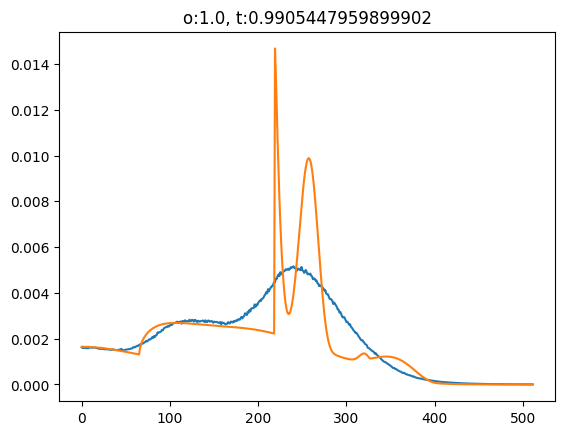

In [24]:
loaded_model = MLP().to(device)
loaded_model.load_state_dict(torch.load("best_model.pt", map_location=device))

outputs = loaded_model(inputs)
i = np.random.randint(0,64)
plt.plot(outputs[i].detach().cpu().numpy())
plt.plot(targets[i].detach().cpu().numpy())
plt.title(f"o:{outputs[0].sum().detach().cpu().numpy()}, t:{targets[0].sum().detach().cpu().numpy()}")
plt.show()